In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from typing import Sequence

from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    render_rgb_view,
    _interpolate_vertex_colors,
    triangulate_rgbd_grid,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    triangulate_segments,
)

In [2]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    # ('power-drill', 'power-drill.obj'),
    # ('bleach', 'bleach.obj'),
    # ('pitcher', 'pitcher.obj'),
    # ('mug', 'mug.obj'),
    # ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

meshes = dict()
for foldername,filename in names:
    print(f'Getting the {filename.split('.')[0]}')
    
    mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(mesh)
    mesh.compute_vertex_normals()

    meshes[foldername] = mesh

meshlist = list(meshes.values())

Getting the mustard-bottle
Getting the table


In [3]:
centres = []
for meshname, mesh in meshes.items():
    if meshname == 'table':
        continue
    centres.append(mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

In [ ]:
mesh: o3d.geometry.TriangleMesh = meshlist
cam_centre=polar2cartesian(1.0, 30, 90)
look_at=obj_centre
dropout_rate: float = 0.0
depth_error_std: float = 0.0
translation_error_std: float = 0.0
rotation_error_std_degs: float = 0.0
width_px: int = 360
height_px: int = 240
fov: float = 70.0
k: float = 3.0

In [5]:
from superprimitive_fusion.scanner import (
    virtual_scan,
    mesh_depth_image,
)

In [ ]:
result = virtual_scan(meshlist, cam_centre, look_at)

mesh = mesh_depth_image(
    points=result['verts'],
    vertex_colours=result['vcols'],
    cam_centre=cam_centre,
    segmentation=result['segmt'],
    normals=result['normals'],
    k=3.5,
)

In [12]:
print(np.asarray(mesh.vertices))

[]


In [8]:
o3d.visualization.draw_geometries([mesh])

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [13]:
def _quad_to_tris(idx: tuple[int, int, int, int],
                  verts: np.ndarray) -> tuple[list[int], list[int]]:
    """Split a quadrilateral into two triangles.

    The shortest diagonal is used for convex quads, while concave quads are
    triangulated so both resulting triangles are oriented counter‑clockwise
    (positive signed area).
    """
    def signed_area(a, b, c):
        return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

    # Convexity check – all cross products have the same sign
    crosses: list[float] = []
    for i in range(4):
        a, b, c = verts[i], verts[(i + 1) % 4], verts[(i + 2) % 4]
        ab, bc = b - a, c - b
        crosses.append(ab[0] * bc[1] - ab[1] * bc[0])
    is_convex = all(cp > 0 for cp in crosses)

    if is_convex:
        # pick the shorter diagonal
        d0 = np.sum((verts[0] - verts[2]) ** 2)
        d1 = np.sum((verts[1] - verts[3]) ** 2)
        if d0 <= d1:
            return [idx[0], idx[1], idx[2]], [idx[0], idx[2], idx[3]]
        return [idx[0], idx[1], idx[3]], [idx[1], idx[2], idx[3]]

    # Concave: test both diagonals for valid (positive‑area) triangles
    sa = [signed_area(*verts[[0, 1, 2]]), signed_area(*verts[[0, 2, 3]]),
          signed_area(*verts[[0, 1, 3]]), signed_area(*verts[[1, 2, 3]])]
    split1_ok = sa[0] > 0 and sa[1] > 0  # (0,1,2) & (0,2,3)
    split2_ok = sa[2] > 0 and sa[3] > 0  # (0,1,3) & (1,2,3)
    if split1_ok or not split2_ok:
        return [idx[0], idx[1], idx[2]], [idx[0], idx[2], idx[3]]
    return [idx[0], idx[1], idx[3]], [idx[1], idx[2], idx[3]]

def _interpolate_vertex_colors(
        mesh: o3d.geometry.TriangleMesh,
        primitive_ids: np.ndarray,
        bary_uv: np.ndarray
    ) -> np.ndarray:
    """Return RGB at hit points: sample texture if available, else barycentric vertex colors."""
    assert primitive_ids.ndim == 1 and bary_uv.ndim == 2, "Must not be img shape"

    # Texture path
    has_uvs = getattr(mesh, "has_triangle_uvs", lambda: False)()
    has_textures = hasattr(mesh, "textures") and len(mesh.textures) > 0
    if has_uvs and has_textures:
        # (3 * n_tris, 2) -> (n_tris, 3, 2)
        tri_uvs_all = np.asarray(mesh.triangle_uvs, dtype=np.float32).reshape(-1, 3, 2)
        tri_uvs = tri_uvs_all[primitive_ids]  # (N, 3, 2) for the hit triangles

        # Barycentric -> UV on the triangle
        u, v = bary_uv[:, 0], bary_uv[:, 1]
        w = 1.0 - u - v
        hit_uv = (tri_uvs[:, 0, :] * w[:, None] +
                  tri_uvs[:, 1, :] * u[:, None] +
                  tri_uvs[:, 2, :] * v[:, None]).astype(np.float32)

        # Choose texture per triangle if available; else use texture 0 for all.
        if hasattr(mesh, "triangle_material_ids") and len(mesh.textures) > 1:
            tri_mats_all = np.asarray(mesh.triangle_material_ids, dtype=np.int32)
            mat_ids = tri_mats_all[primitive_ids]
        else:
            mat_ids = np.zeros(len(hit_uv), dtype=np.int32)

        out = np.zeros((len(hit_uv), 3), dtype=np.float32)

        # Sample each texture group (bilinear)
        unique_tex = np.unique(mat_ids)
        for tex_id in unique_tex:
            mask = (mat_ids == tex_id)
            if not np.any(mask):
                continue

            img = np.asarray(mesh.textures[int(tex_id)])
            # Ensure H * W * C
            if img.ndim == 2:
                img = np.repeat(img[..., None], 3, axis=2)
            if img.shape[2] > 3:
                img = img[..., :3]  # drop alpha

            H, W = img.shape[0], img.shape[1]
            uv = np.clip(hit_uv[mask], 0.0, 1.0)
            x = uv[:, 0] * (W - 1)
            y = uv[:, 1] * (H - 1)

            x0 = np.floor(x).astype(np.int32)
            y0 = np.floor(y).astype(np.int32)
            x1 = np.clip(x0 + 1, 0, W - 1)
            y1 = np.clip(y0 + 1, 0, H - 1)

            wa = (x1 - x) * (y1 - y)
            wb = (x - x0) * (y1 - y)
            wc = (x1 - x) * (y - y0)
            wd = (x - x0) * (y - y0)

            Ia = img[y0, x0, :].astype(np.float32)
            Ib = img[y0, x1, :].astype(np.float32)
            Ic = img[y1, x0, :].astype(np.float32)
            Id = img[y1, x1, :].astype(np.float32)

            col = (Ia * wa[:, None] + Ib * wb[:, None] +
                   Ic * wc[:, None] + Id * wd[:, None]) / 255.0
            out[mask] = col

        return out

    # --- Fallback: per-vertex color interpolation ---
    vcols = np.asarray(mesh.vertex_colors, dtype=np.float32)
    tris = np.asarray(mesh.triangles, dtype=np.int32)[primitive_ids]
    c0, c1, c2 = vcols[tris[:, 0]], vcols[tris[:, 1]], vcols[tris[:, 2]]
    u, v = bary_uv[:, 0], bary_uv[:, 1]
    w = 1.0 - u - v
    return w[:, None] * c0 + u[:, None] * c1 + v[:, None] * c2


In [ ]:
###############
# Ray casting #
###############
scene = o3d.t.geometry.RaycastingScene()
geom_ids = []
for name,mesh in meshes.items():
    id = scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))
    geom_ids.append(id)
    print(f'{name} is geom id {id}')

rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
    fov_deg=fov,
    center=list(look_at),
    eye=list(cam_centre),
    up=[0, 0, 1],
    width_px=width_px,
    height_px=height_px,
)

ans = scene.cast_rays(rays)
t_hit = ans["t_hit"].numpy()

# Intersection metadata (gometry id + triangle id + barycentric uv + normals)
geom_ids = ans["geometry_ids"].numpy().astype(np.int16)
geom_ids[geom_ids > 1e2] = -1
prim_ids = ans["primitive_ids"].numpy().astype(np.int32)
bary_uv = ans.get("primitive_uvs", None).numpy()
normals = ans["primitive_normals"]

mustard-bottle is geom id 0
table is geom id 1


In [15]:
valid = np.isfinite(t_hit).reshape(-1)

In [16]:
########################
# Generate 3‑D vertices#
########################
rays_np = rays.numpy()  # (H*W,6)
origins = rays_np[..., :3]
dirs = rays_np[..., 3:]
noise = (depth_error_std * np.random.randn(*t_hit.shape)).astype(np.float32)
t_noisy = t_hit + noise
verts = origins + dirs * t_noisy[..., None]

In [17]:
#############################
# Colour interpolation step #
#############################
vcols = np.full((*t_hit.shape, 3), 0.5)

# Assertions for bugfixing
assert bary_uv is not None
for mesh in meshlist:
    assert mesh.has_vertex_colors()

for id in range(len(meshlist)):
    rel_prim_ids = prim_ids[geom_ids==id]
    rel_bary_uv  =  bary_uv[geom_ids==id]
    vcols[geom_ids==id] = _interpolate_vertex_colors(meshlist[id], rel_prim_ids, rel_bary_uv)

In [38]:
from superprimitive_fusion.scanner import triangulate_rgbd_grid

points:         np.ndarray = result['verts']
vertex_colours: np.ndarray = result['vcols']
cam_centre:     np.ndarray | tuple = cam_centre
segmentation:   np.ndarray | None = result['segmt']
normals:        np.ndarray | None = result['norms']
k = 3.5
assert points.ndim == 3
if vertex_colours.ndim == 3:
    vertex_colours = vertex_colours.reshape(-1, 3)
if segmentation is not None:
    assert segmentation.ndim == 2
if normals is not None:
    assert normals.ndim == 3
    
z = np.linalg.norm((points - cam_centre), axis=2)
    
valid_img = np.ones_like(segmentation, dtype=bool)
valid_img[segmentation==-1] = 0

tris = triangulate_rgbd_grid(
    verts=points,
    valid=valid_img.reshape(-1),
    z=z,
    obj_id=segmentation,
    k=k,
    normals=None,
    max_normal_angle_deg=None,
).astype(np.int32)

print(f'There are {len(tris)} triangles')

There are 83741 triangles


In [30]:
np.testing.assert_array_almost_equal(points,verts)
np.testing.assert_array_almost_equal(valid_img.reshape(-1),valid)
np.testing.assert_array_almost_equal(z,t_hit)
np.testing.assert_array_almost_equal(segmentation,t_hit)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 43893 / 86400 (50.8%)
 ACTUAL: array([ True,  True,  True, ...,  True,  True,  True], shape=(86400,))
 DESIRED: array([ True,  True,  True, ..., False, False, False], shape=(86400,))

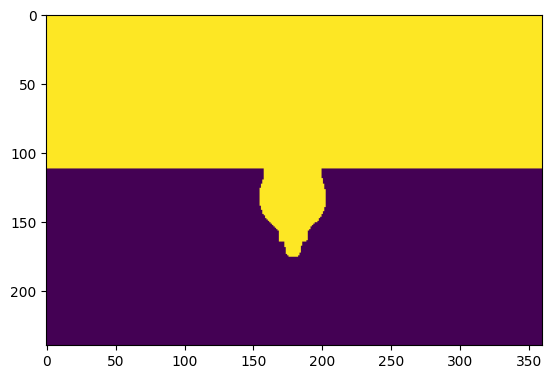

In [32]:
plt.imshow(valid.reshape(240,360))

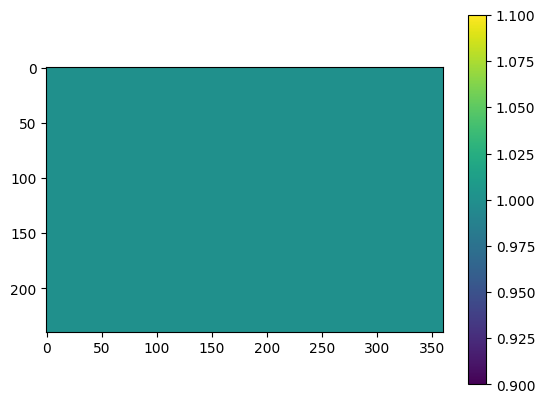

In [35]:
plt.imshow(valid_img)
plt.colorbar()

In [20]:
tris = triangulate_rgbd_grid(
    verts=verts,
    valid=valid,
    z=t_hit,
    obj_id=geom_ids,
    k=3.5,
    normals=None,                   # or your per-pixel normals (H,W,3)
    max_normal_angle_deg=None       # e.g. 60 to be stricter on folds
).astype(np.int32)

In [ ]:
mesh_out = o3d.geometry.TriangleMesh()
mesh_out.vertices = o3d.utility.Vector3dVector(verts.reshape(-1, 3))
mesh_out.triangles = o3d.utility.Vector3iVector(tris[:, [0,2,1]])

if vcols is not None:
    mesh_out.vertex_colors = o3d.utility.Vector3dVector(vcols.reshape(-1,3))

#############################
# Clean‑up / post‑processing#
#############################
mesh_out.remove_unreferenced_vertices()
mesh_out.remove_degenerate_triangles()
mesh_out.remove_duplicated_triangles()
mesh_out.remove_non_manifold_edges()
mesh_out.compute_vertex_normals()

######################
# Registration error #
######################
mesh_out.translate(tuple(np.random.randn(3) * translation_error_std))
R = mesh.get_rotation_matrix_from_xyz(
    tuple(np.random.randn(3) * np.deg2rad(rotation_error_std_degs))
)
mesh_out.rotate(R, center=mesh_out.get_center())

mesh = mesh_out

In [ ]:
o3d.visualization.draw_geometries([mesh])